<a href="https://colab.research.google.com/github/AdamChoong0095/NUS-Stock-Data/blob/Adam/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price CS3244 project
The goals of this project are:
* To determine an effective model with justificaiton for predicting stock prices of the S&P500
* To determine if the S&P500 is a good indicator of performance for other companies contained in the top 500 performing companies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
sp500=pd.read_csv('/content/drive/MyDrive/cs3244_data/ETFs/spy.us.txt')
sp500.drop(columns={'OpenInt','Volume'}, inplace=True)
# Create empty lists to store the new data
dates = []
prices = []
price_types = []

# Iterate through the DataFrame
for index, row in sp500.iterrows():
  date = row['Date']
  open_price = row['Open']
  high_price = row['High']
  low_price = row['Low']
  close_price = row['Close']

  # Append the data to the lists
  dates.extend([date] * 4)  # Repeat the date 4 times
  prices.extend([open_price, high_price, low_price, close_price])
  price_types.extend(['open', 'high', 'low', 'close'])

# Create a new DataFrame
sp500 = pd.DataFrame({'Date': dates, 'Price': prices, 'Type of Price': price_types})

In [3]:
# Group the DataFrame by Date and Type of Price
grouped = sp500.groupby(['Date', 'Type of Price'])

# Calculate the average price for each date and type
avg_prices = grouped['Price'].mean().reset_index()

# Create a dictionary to store the average high and low prices for each date
avg_high_low = {}

# Iterate through the average prices
for index, row in avg_prices.iterrows():
  date = row['Date']
  price_type = row['Type of Price']
  price = row['Price']

  if date not in avg_high_low:
    avg_high_low[date] = {}

  if price_type == 'high' or price_type == 'low':
    avg_high_low[date][price_type] = price

# Iterate through the DataFrame and replace high and low prices with the average
for index, row in sp500.iterrows():
  date = row['Date']
  price_type = row['Type of Price']

  if price_type == 'high' or price_type == 'low' and date in avg_high_low:
    sp500.loc[index, 'Price'] = avg_high_low[date][price_type]


In [4]:
# Create a new DataFrame to store the modified data
new_sp500 = pd.DataFrame(columns=['Date', 'Price', 'Type of Price'])

# Iterate through the DataFrame
i = 0
while i < len(sp500):
  row = sp500.iloc[i]
  if row['Type of Price'] == 'high':
    # Check if the next row exists and is 'low'
    if i + 1 < len(sp500) and sp500.iloc[i + 1]['Type of Price'] == 'low':
      # Calculate the average of the high and low prices
      average_price = (row['Price'] + sp500.iloc[i + 1]['Price']) / 2
      # Add a new row with the average price and label 'average'
      new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [average_price], 'Type of Price': ['average']})], ignore_index=True)
      i += 2  # Skip the next row (low)
    else:
      # If the next row is not 'low', keep the current row as it is
      new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
      i += 1
  else:
    # If the current row is not 'high', keep it as it is
    new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
    i += 1

# Replace the original sp500 DataFrame with the modified one
sp500 = new_sp500

<ipython-input-4-aca80bd1370c>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)


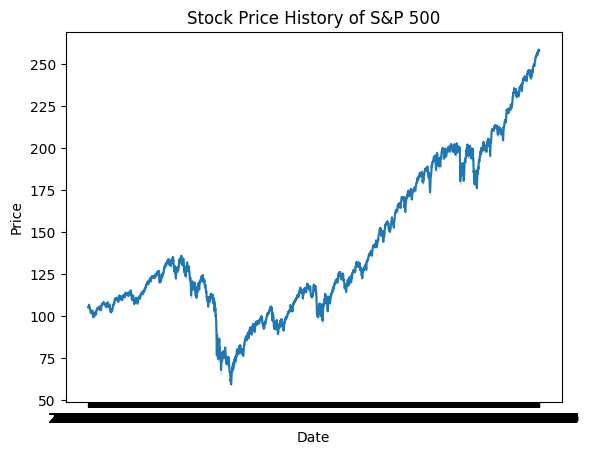

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
graph_sp500_prices=sp500.drop(columns='Type of Price')
sns.lineplot(data=graph_sp500_prices,x='Date',y='Price')
plt.title('Stock Price History of S&P 500')
plt.show()

## Method
To achieve the first goal, we will tune hyperparameters of different models to achieve the best performance possible for each type of model (based on multiple metrics)
* Split data into 80/20 proportion (4 years of training to predict 1 year of prices) to mitigate the effect of overfitting or underfitting. For training/validation, we try cross validation on time series (recommended but more computationally expensive, see code below)
* Select classical models and use cross validation on hyperparameter space for each type to achieve the best performance (measured by accuracy, error and other metrics)
* Compare between model types and ascertain the best model for predicting prices.
* Apply the selected model to an assortment of companies contained in the S&P500.
* The purpose of doing this will be to demonstrate whether or not this approach of model selection generalises well on stock price prediction.

The reasoning behind this approach is that the S&P500 is a traditional indicator (by definition) of the performance of the 500 most dominant stocks in Wall Street.

In [17]:
#perform unique time series cross validation (instead of stochastic selection of subsets, we select ordered subsets to train and validate models)
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
train_size = int(len(sp500) * 0.8)
sp500.drop(columns=['Date','Type of Price'],inplace=True)
sp500_train = sp500[:train_size]
sp500_test = sp500[train_size:]
tscv=TimeSeriesSplit(n_splits=5)
cv_data=[]
for train_idx,validate_idx in tscv.split(sp500_train):
  train=sp500_train.iloc[train_idx]
  validate=sp500_train.iloc[validate_idx]
  cv_data.append((train,validate))

We will only focus on time series specific modelling techniques that can capture the sequential nature of our data because of our project's method which is to use historical prices to predict future prices. This means models like SVR or random forests which generally perform poorly when trying to capture trends in time series data will be excluded. Further reasoning for excluding these models is also because of the lack of other features than price, volume (which we exclude because of our lack of justificaiton or understanding for including this feature) and date

### ARIMA approach

### GARCH approach

### Neural Network (CNN, RNN and LSTM) approach


### Hybrid approach

## Evaluation and Discussion

## Conclusion